Tutorial 4 - https://www.cienciadedatos.net/documentos/py39-forecasting-time-series-with-skforecast-xgboost-lightgbm-catboost.html

In [2]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelling and Forecasting
# ==============================================================================
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

# Configuration
# ==============================================================================
import warnings
#warnings.filterwarnings('ignore')

In [4]:
# Downloading data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-'
       'learning-python/master/data/bike_sharing_dataset_clean.csv')
data = pd.read_csv(url)
data['date_time'] = pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S')
data = data.set_index('date_time')
data = data.asfreq('H')
data = data.sort_index()
data

,holiday,workingday,weather,temp,atemp,hum,windspeed,users,month,hour,weekday
date_time,,,,,,,,,,,
2011-01-01 00:00:00,0.0,0.0,clear,9.84,14.395,81.0,0.0000,16.0,1,0,5
2011-01-01 01:00:00,0.0,0.0,clear,9.02,13.635,80.0,0.0000,40.0,1,1,5
2011-01-01 02:00:00,0.0,0.0,clear,9.02,13.635,80.0,0.0000,32.0,1,2,5
2011-01-01 03:00:00,0.0,0.0,clear,9.84,14.395,75.0,0.0000,13.0,1,3,5
2011-01-01 04:00:00,0.0,0.0,clear,9.84,14.395,75.0,0.0000,1.0,1,4,5
...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,0.0,1.0,mist,10.66,12.880,60.0,11.0014,119.0,12,19,0
2012-12-31 20:00:00,0.0,1.0,mist,10.66,12.880,60.0,11.0014,89.0,12,20,0
2012-12-31 21:00:00,0.0,1.0,clear,10.66,12.880,60.0,11.0014,90.0,12,21,0


In [5]:
# Split train-val-test
# ==============================================================================
end_train = '2012-03-31 23:59:00'
end_validation = '2012-08-31 23:59:00'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2011-01-01 00:00:00 --- 2012-03-31 23:00:00  (n=10944)
Dates validacion : 2012-04-01 00:00:00 --- 2012-08-31 23:00:00  (n=3672)
Dates test       : 2012-09-01 00:00:00 --- 2012-12-31 23:00:00  (n=2928)


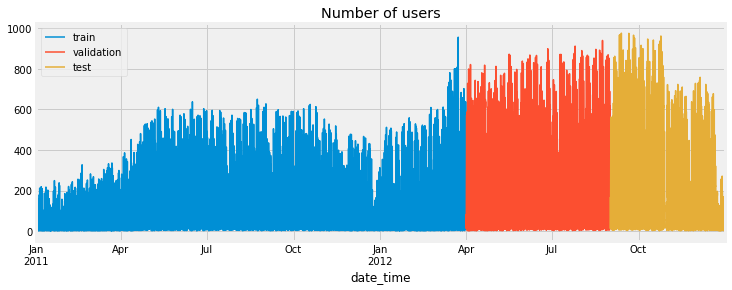

In [6]:
# Plot time series
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
data_train['users'].plot(ax=ax, label='train')
data_val['users'].plot(ax=ax, label='validation')
data_test['users'].plot(ax=ax, label='test')
ax.set_title('Number of users')
ax.legend();

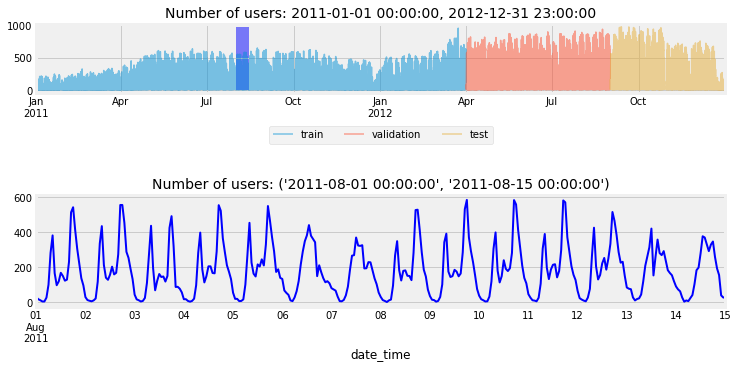

In [7]:
#  Plot time series with zoom
# ==============================================================================
zoom = ('2011-08-01 00:00:00','2011-08-15 00:00:00')

fig = plt.figure(figsize=(11, 6))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)

main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])

data_train['users'].plot(ax=main_ax, label='train', alpha=0.5)
data_val['users'].plot(ax=main_ax, label='validation', alpha=0.5)
data_test['users'].plot(ax=main_ax, label='test', alpha=0.5)
min_y = min(data['users'])
max_y = max(data['users'])
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')
main_ax.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.8))

data.loc[zoom[0]: zoom[1]]['users'].plot(ax=zoom_ax, color='blue', linewidth=2)

main_ax.set_title(f'Number of users: {data.index.min()}, {data.index.max()}', fontsize=14)
zoom_ax.set_title(f'Number of users: {zoom}', fontsize=14)
plt.subplots_adjust(hspace=1)

In [8]:
# Interactive plot of time series
# ==============================================================================
data.loc[:end_train, 'partition'] = 'train'
data.loc[end_train:end_validation, 'partition'] = 'validation'
data.loc[end_validation:, 'partition'] = 'test'

fig = px.line(
    data_frame = data.reset_index(),
    x      = 'date_time',
    y      = 'users',
    color  = 'partition',
    title  = 'Number of users',
    width  = 900,
    height = 500
)

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

fig.show()

data=data.drop(columns='partition')

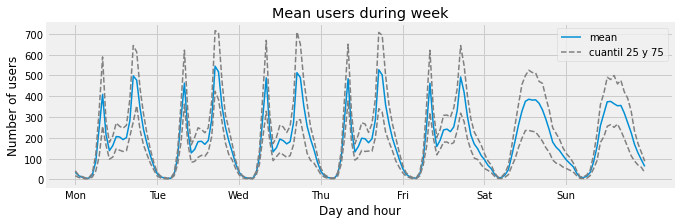

In [9]:
# Boxplot chart for daily seasonality
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 3))
mean_day_hour = data.groupby(["weekday", "hour"])["users"].mean()
q25_dia_hora = data.groupby(["weekday", "hour"])["users"].quantile(0.25)
q75_dia_hora = data.groupby(["weekday", "hour"])["users"].quantile(0.75)

mean_day_hour.plot(ax=ax, label='mean')
q25_dia_hora.plot(ax=ax, linestyle='dashed', color='gray', label='')
q75_dia_hora.plot(ax=ax, linestyle='dashed', color='gray', label='cuantil 25 y 75')


ax.set(
    title="Mean users during week",
    xticks=[i * 24 for i in range(7)],
    xticklabels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    xlabel="Day and hour",
    ylabel="Number of users"
)

ax.legend();

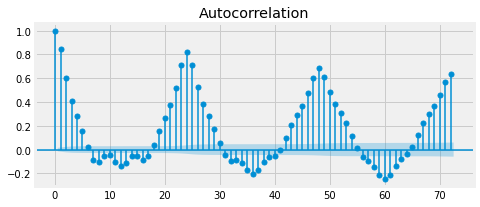

In [10]:
# Autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_acf(data['users'], ax=ax, lags=72)
plt.show()

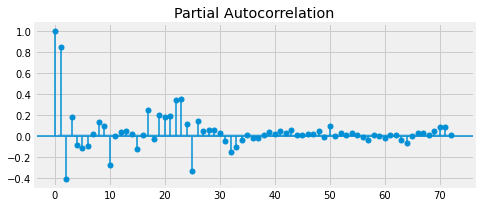

In [11]:
# Partial autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_pacf(data['users'], ax=ax, lags=72, method='ywm')
plt.show()

In [12]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags = 24
                )

forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=123, ...) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: False 
Type of exogenous 

In [13]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }

# Lags used as predictors
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]


results_grid = grid_search_forecaster(
        forecaster         = forecaster,
        y                  = data.loc[:end_validation, 'users'], # Train and validation data
        param_grid         = param_grid,
        lags_grid          = lags_grid,
        steps              = 36,
        refit              = False,
        metric             = 'mean_squared_error',
        initial_train_size = int(len(data_train)), # Model is trained with trainign data
        fixed_train_size   = False,
        return_best        = True,
        verbose            = False
        )

Number of models compared: 48.


loop lags_grid: 100%|██████████████████████████████████████| 4/4 [08:29<00:00, 127.34s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 13132.573900322006



In [14]:
# Results of grid search
# ==============================================================================
results_grid.head(10)

,lags,params,mean_squared_error,learning_rate,max_depth,n_estimators
33,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",13132.573900,0.10,5.0,500.0
32,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",14407.853484,0.10,5.0,100.0
21,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",14677.093172,0.10,5.0,500.0
34,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",14959.220470,0.10,10.0,100.0
19,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",15135.992088,0.10,3.0,500.0
31,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",15198.601754,0.10,3.0,500.0
35,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",15527.191495,0.10,10.0,500.0
23,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",15922.192863,0.10,10.0,500.0
27,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",16312.056663,0.01,5.0,500.0
22,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",16431.762039,0.10,10.0,100.0


In [15]:
print(backtesting_forecaster.__doc__)


    Backtesting of forecaster model.

    If `refit` is False, the model is trained only once using the `initial_train_size`
    first observations. If `refit` is True, the model is trained in each iteration
    increasing the training set. A copy of the original forecaster is created so 
    it is not modified during the process.

    Parameters
    ----------
    forecaster : ForecasterAutoreg, ForecasterAutoregCustom, ForecasterAutoregDirect
        Forecaster model.
        
    y : pandas Series
        Training time series.
    
    steps : int
        Number of steps to predict.
        
    metric : str, callable, list
        Metric used to quantify the goodness of fit of the model.
        
        If string:
            {'mean_squared_error', 'mean_absolute_error',
             'mean_absolute_percentage_error', 'mean_squared_log_error'}
    
        If callable:
            Function with arguments y_true, y_pred that returns a float.

        If list:
            List conta

In [16]:
# Backtesting test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
    forecaster = forecaster,
    y          = data['users'],
    initial_train_size = len(data.loc[:end_validation]),
    fixed_train_size   = False,
    steps      = 36,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False # Change to True to see detailed information
    )

print(f"Backtest error: {metric}")

Backtest error: 11600.731121370716


In [17]:
# Predictions
# ==============================================================================
predictions

,pred
2012-09-01 00:00:00,127.918144
2012-09-01 01:00:00,73.119354
2012-09-01 02:00:00,44.164623
2012-09-01 03:00:00,22.474485
2012-09-01 04:00:00,8.992602
...,...
2012-12-31 19:00:00,175.942596
2012-12-31 20:00:00,112.338333
2012-12-31 21:00:00,84.962578
2012-12-31 22:00:00,57.712727


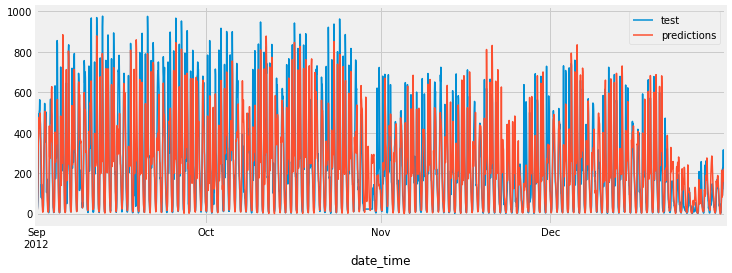

In [18]:
# Plot of predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
data_test['users'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predictions')
ax.legend();

In [19]:
# Interactive plot of predictions
# ==============================================================================
data_plot = pd.DataFrame({
                'test': data_test['users'],
                'prediction': predictions['pred'],
                 })
data_plot.index.name = 'date_time'

fig = px.line(
        data_frame = data_plot.reset_index(),
        x      = 'date_time',
        y      = data_plot.columns,
        title  = 'Number of users',
        width  = 900,
        height = 500
      )

fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [20]:
# Store categorical variables as category type
# ==============================================================================
data['weather'] = data['weather'].astype('category')
data['month']   = data['month'].astype('category')
data['weekday'] = data['weekday'].astype('category')

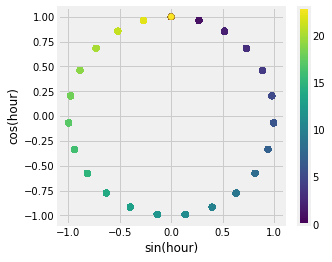

In [21]:
# Transformation sine-cosine of variable hour
# ==============================================================================
data['hour_sin'] = np.sin(data['hour'] / 23 * 2 * np.pi)
data['hour_cos'] = np.cos(data['hour'] / 23 * 2 * np.pi)

# Plot of the transformation
# ==============================================================================
fig, ax = plt.subplots(figsize=(4.5, 4))
sp = ax.scatter(data["hour_sin"], data["hour_cos"], c=data["hour"])
ax.set(
    xlabel="sin(hour)",
    ylabel="cos(hour)",
)
_ = fig.colorbar(sp)

data = data.drop(columns='hour')

In [22]:
# One hot encoding
# ==============================================================================
data = pd.get_dummies(data, columns=['weather', 'month', 'weekday'])
data.head(3)

,holiday,workingday,temp,atemp,hum,windspeed,users,hour_sin,hour_cos,weather_clear,...,month_10,month_11,month_12,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
date_time,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,0.0,0.0,9.84,14.395,81.0,0.0,16.0,0.000000,1.000000,1,...,0,0,0,0,0,0,0,0,1,0
2011-01-01 01:00:00,0.0,0.0,9.02,13.635,80.0,0.0,40.0,0.269797,0.962917,1,...,0,0,0,0,0,0,0,0,1,0
2011-01-01 02:00:00,0.0,0.0,9.02,13.635,80.0,0.0,32.0,0.519584,0.854419,1,...,0,0,0,0,0,0,0,0,1,0


In [23]:
# Select exogenous variables, including those generated by one hot encoding.
exog_variables = [column for column in data.columns
                      if column.startswith(('weather', 'month', 'hour', 'weekday'))]
exog_variables.extend(['holiday', 'temp', 'atemp', 'hum', 'windspeed'])
exog_variables

['hour_sin',
 'hour_cos',
 'weather_clear',
 'weather_mist',
 'weather_rain',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
 'weekday_0',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6',
 'holiday',
 'temp',
 'atemp',
 'hum',
 'windspeed']

In [24]:
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

In [25]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags = 24
             )

In [26]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }

# Lags used as predictors
lags_grid = [72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
                    forecaster         = forecaster,
                    y                  = data.loc[:end_validation, 'users'],
                    exog               = data.loc[:end_validation, exog_variables],
                    param_grid         = param_grid,
                    lags_grid          = lags_grid,
                    steps              = 36,
                    refit              = False,
                    metric             = 'mean_squared_error',
                    initial_train_size = int(len(data_train)),
                    fixed_train_size   = False,
                    return_best        = True,
                    verbose            = False
               )

Number of models compared: 24.


loop lags_grid: 100%|██████████████████████████████████████| 2/2 [06:28<00:00, 194.47s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 8912.662678308314



In [27]:
# Backtesting test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = data['users'],
                            exog               = data[exog_variables],
                            initial_train_size = len(data.loc[:end_validation]),
                            fixed_train_size   = False,
                            steps              = 36,
                            refit              = False,
                            metric             = 'mean_squared_error',
                            verbose            = False
                      )

print(f"Backtest error: {metric}")

Backtest error: 6329.923373865322


In [28]:
# Extract feature importance
# ==============================================================================
importance = forecaster.get_feature_importance()
importance

,feature,importance
0,lag_1,0.238312
1,lag_2,0.005868
2,lag_3,0.003568
3,lag_4,0.006380
4,lag_5,0.002033
...,...,...
96,holiday,0.001502
97,temp,0.001735
98,atemp,0.002874
99,hum,0.001311


LightGBM

In [29]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=123),
                lags = 24
             )

forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
Creation date: 2023-04-19 19:39:47 
Last fit date: None 
Skforecast version: 0.6.0 
Python version: 3.9.7 

In [30]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags used as predictors
lags_grid = [72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data.loc[:end_validation, 'users'],
                        exog               = data.loc[:end_validation, exog_variables],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = 36,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
              )


Number of models compared: 24.


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:55<00:00, 27.63s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}
  Backtesting metric: 8814.536841168821



In [31]:
# Results grid search
# ==============================================================================
results_grid.head(10)

,lags,params,mean_squared_error,learning_rate,max_depth,n_estimators
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",8814.536841,0.10,10.0,500.0
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",8838.983329,0.10,3.0,500.0
23,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",9033.934124,0.10,10.0,500.0
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",9034.016763,0.10,5.0,500.0
21,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",9460.577093,0.10,5.0,500.0
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",9699.111031,0.10,10.0,100.0
19,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",10234.834660,0.10,3.0,500.0
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",10844.341010,0.10,5.0,100.0
22,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",11092.127609,0.10,10.0,100.0
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",11938.993487,0.01,10.0,500.0


In [32]:
# Backtesting test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                        forecaster         = forecaster,
                        y                  = data['users'],
                        exog               = data[exog_variables],
                        initial_train_size = len(data.loc[:end_validation]),
                        fixed_train_size   = False,
                        steps              = 36,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        verbose            = False
                      )

print(f"Backtest error: {metric}")

Backtest error: 5932.916858803713


In [33]:
# Feature importance
# ==============================================================================
impotance = forecaster.get_feature_importance()
impotance

,feature,importance
0,lag_1,785
1,lag_2,300
2,lag_3,208
3,lag_4,300
4,lag_5,186
...,...,...
96,holiday,22
97,temp,195
98,atemp,201
99,hum,284


Catboost

In [34]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = CatBoostRegressor(random_state=123, silent=True),
                lags = 24
             )

forecaster

ForecasterAutoreg 
Regressor: <catboost.core.CatBoostRegressor object at 0x000002BF1DFB6A60> 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'loss_function': 'RMSE', 'silent': True, 'random_state': 123} 
Creation date: 2023-04-19 19:41:35 
Last fit date: None 
Skforecast version: 0.6.0 
Python version: 3.9.7 

In [35]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags used as predictors
lags_grid = [72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data.loc[:end_validation, 'users'],
                        exog               = data.loc[:end_validation, exog_variables],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = 36,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 24.


loop lags_grid: 100%|██████████████████████████████████████| 2/2 [09:25<00:00, 282.57s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 6779.454203090569



In [36]:
# Results grid search
# ==============================================================================
results_grid.head(10)

,lags,params,mean_squared_error,learning_rate,max_depth,n_estimators
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",6779.454203,0.1,5.0,500.0
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",8013.664614,0.1,3.0,500.0
21,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",8107.921257,0.1,5.0,500.0
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",9269.532296,0.1,10.0,500.0
23,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",9613.039031,0.1,10.0,500.0
19,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",9696.337248,0.1,3.0,500.0
22,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",10396.453214,0.1,10.0,100.0
20,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",10670.330703,0.1,5.0,100.0
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",11129.672504,0.1,5.0,100.0
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",11467.609975,0.1,10.0,100.0


In [37]:
# Backtesting test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = data['users'],
                            exog               = data[exog_variables],
                            initial_train_size = len(data.loc[:end_validation]),
                            fixed_train_size   = False,
                            steps              = 36,
                            refit              = False,
                            metric             = 'mean_squared_error',
                            verbose            = False
                       )

print(f"Backtest error: {metric}")

Backtest error: 5801.144365058469
